<a href="https://colab.research.google.com/github/narayanacharya6/CanvasFun/blob/master/Example_Deu_Eng_MT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Mount Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd 'drive/My Drive/Projects-Scratchpad/NLP/German-To-English-MT'

/content/drive/My Drive/Projects-Scratchpad/NLP/German-To-English-MT


### Get data if not done already!

In [0]:
!mkdir -p data

In [31]:
%cd data

/content/drive/My Drive/Projects-Scratchpad/NLP/German-To-English-MT/data


In [19]:
!wget http://www.manythings.org/anki/deu-eng.zip

--2020-02-09 22:47:07--  http://www.manythings.org/anki/deu-eng.zip
Resolving www.manythings.org (www.manythings.org)... 104.24.108.196, 104.24.109.196, 2606:4700:3037::6818:6cc4, ...
Connecting to www.manythings.org (www.manythings.org)|104.24.108.196|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7747747 (7.4M) [application/zip]
Saving to: ‘deu-eng.zip’

deu-eng.zip         100%[===================>]   7.39M  4.47MB/s    in 1.7s    

2020-02-09 22:47:09 (4.47 MB/s) - ‘deu-eng.zip’ saved [7747747/7747747]



In [32]:
!unzip deu-eng.zip

Archive:  deu-eng.zip
  inflating: deu.txt                 
  inflating: _about.txt              


In [33]:
!ls -lrt
%cd ..

total 38797
-rw------- 1 root root  7747747 Jan 11 14:49 deu-eng.zip
-rw------- 1 root root 31978057 Jan 11 23:49 deu.txt
-rw------- 1 root root     1441 Jan 11 23:49 _about.txt
/content/drive/My Drive/Projects-Scratchpad/NLP/German-To-English-MT


In [1]:
!ls -lrt

total 8
drwxr-xr-x 1 root root 4096 Feb  5 18:37 sample_data
drwx------ 4 root root 4096 Feb  9 23:17 drive


### Upgrade to TensorFlow 2

In [4]:
!pip uninstall tensorflow

Uninstalling tensorflow-1.15.0:
  Would remove:
    /usr/local/bin/estimator_ckpt_converter
    /usr/local/bin/freeze_graph
    /usr/local/bin/saved_model_cli
    /usr/local/bin/tensorboard
    /usr/local/bin/tf_upgrade_v2
    /usr/local/bin/tflite_convert
    /usr/local/bin/toco
    /usr/local/bin/toco_from_protos
    /usr/local/lib/python3.6/dist-packages/tensorflow-1.15.0.dist-info/*
    /usr/local/lib/python3.6/dist-packages/tensorflow/*
    /usr/local/lib/python3.6/dist-packages/tensorflow_core/*
Proceed (y/n)? y
  Successfully uninstalled tensorflow-1.15.0


In [5]:
!pip install tensorflow

     |████████████████████████████████| 421.8MB 36kB/s 
     |████████████████████████████████| 450kB 38.1MB/s 
     |████████████████████████████████| 3.8MB 35.2MB/s 
     |████████████████████████████████| 81kB 10.0MB/s 
ERROR: tensorboard 2.1.0 has requirement grpcio>=1.24.3, but you'll have grpcio 1.15.0 which is incompatible.
ERROR: google-colab 1.0.0 has requirement google-auth~=1.4.0, but you'll have google-auth 1.11.0 which is incompatible.
  Found existing installation: tensorflow-estimator 1.15.1
    Uninstalling tensorflow-estimator-1.15.1:
      Successfully uninstalled tensorflow-estimator-1.15.1
  Found existing installation: google-auth 1.4.2
    Uninstalling google-auth-1.4.2:
      Successfully uninstalled google-auth-1.4.2
  Found existing installation: tensorboard 1.15.0
    Uninstalling tensorboard-1.15.0:
      Successfully uninstalled tensorboard-1.15.0


### Lets get started!

In [4]:
import string
import re
from numpy import array, argmax, random, take
import pandas as pd
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding, RepeatVector
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import load_model
from tensorflow.keras import optimizers
import matplotlib.pyplot as plt

print(tf.__version__)

%matplotlib inline
pd.set_option('display.max_colwidth', 200)

2.1.0


In [0]:
# function to read raw text file
def read_text(filename):
  # open the file
  file = open(filename, mode='rt', encoding='utf-8')

  # read all text
  text = file.read()
  file.close()
  return text

# split a text into sentences
def to_lines(text):
  sents = text.strip().split('\n')
  sents = [i.split('\t') for i in sents]
  return sents

In [0]:
data = read_text("data/deu.txt")
deu_eng = to_lines(data)
deu_eng = array(deu_eng)

In [7]:
deu_eng

array([['Hi.', 'Hallo!',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #380701 (cburgmer)'],
       ['Hi.', 'Grüß Gott!',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #659813 (Esperantostern)'],
       ['Run!', 'Lauf!',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #906328 (papabear) & #941078 (Fingerhut)'],
       ...,
       ["If someone who doesn't know your background says that you sound like a native speaker, it means they probably noticed something about your speaking that made them realize you weren't a native speaker. In other words, you don't really sound like a native speaker.",
        'Wenn jemand Fremdes dir sagt, dass du dich wie ein Muttersprachler anhörst, bedeutet das wahrscheinlich: Er hat etwas an deinem Sprechen bemerkt, dass dich als Nicht-Muttersprachler verraten hat. Mit anderen Worten: Du hörst dich nicht wirklich wie ein Muttersprachler an.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #953936 (CK) & 

In [0]:
# Take limited rows depending upon compute!
# deu_eng = deu_eng[:50000,:]

In [0]:
# Remove attribution field
deu_eng = deu_eng[:, :2]

In [10]:
# Remove punctuation
deu_eng[:,0] = [s.translate(str.maketrans('', '', string.punctuation)) for s in deu_eng[:,0]]
deu_eng[:,1] = [s.translate(str.maketrans('', '', string.punctuation)) for s in deu_eng[:,1]]

deu_eng

array([['Hi', 'Hallo'],
       ['Hi', 'Grüß Gott'],
       ['Run', 'Lauf'],
       ...,
       ['If someone who doesnt know your background says that you sound like a native speaker it means they probably noticed something about your speaking that made them realize you werent a native speaker In other words you dont really sound like a native speaker',
        'Wenn jemand Fremdes dir sagt dass du dich wie ein Muttersprachler anhörst bedeutet das wahrscheinlich Er hat etwas an deinem Sprechen bemerkt dass dich als NichtMuttersprachler verraten hat Mit anderen Worten Du hörst dich nicht wirklich wie ein Muttersprachler an'],
       ['It may be impossible to get a completely errorfree corpus due to the nature of this kind of collaborative effort However if we encourage members to contribute sentences in their own languages rather than experiment in languages they are learning we might be able to minimize errors',
        'Es ist wohl unmöglich einen vollkommen fehlerfreien Korpus zu erre

In [11]:
# convert text to lowercase
for i in range(len(deu_eng)):
    deu_eng[i,0] = deu_eng[i,0].lower()
    deu_eng[i,1] = deu_eng[i,1].lower()

deu_eng

array([['hi', 'hallo'],
       ['hi', 'grüß gott'],
       ['run', 'lauf'],
       ...,
       ['if someone who doesnt know your background says that you sound like a native speaker it means they probably noticed something about your speaking that made them realize you werent a native speaker in other words you dont really sound like a native speaker',
        'wenn jemand fremdes dir sagt dass du dich wie ein muttersprachler anhörst bedeutet das wahrscheinlich er hat etwas an deinem sprechen bemerkt dass dich als nichtmuttersprachler verraten hat mit anderen worten du hörst dich nicht wirklich wie ein muttersprachler an'],
       ['it may be impossible to get a completely errorfree corpus due to the nature of this kind of collaborative effort however if we encourage members to contribute sentences in their own languages rather than experiment in languages they are learning we might be able to minimize errors',
        'es ist wohl unmöglich einen vollkommen fehlerfreien korpus zu erre

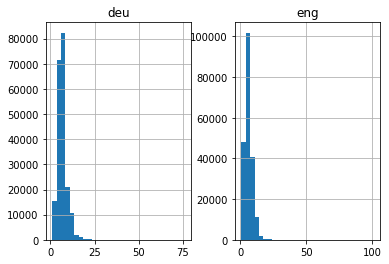

In [12]:
# empty lists
eng_l = []
deu_l = []

# populate the lists with sentence lengths
for i in deu_eng[:,0]:
      eng_l.append(len(i.split()))

for i in deu_eng[:,1]:
      deu_l.append(len(i.split()))

length_df = pd.DataFrame({'eng':eng_l, 'deu':deu_l})

length_df.hist(bins = 30)
plt.show()

In [0]:
# function to build a tokenizer
def tokenization(lines):
  tokenizer = Tokenizer()
  tokenizer.fit_on_texts(lines)
  return tokenizer

In [14]:
# prepare english tokenizer
eng_tokenizer = tokenization(deu_eng[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1

eng_length = 8
print('English Vocabulary Size: %d' % eng_vocab_size)

English Vocabulary Size: 16380


In [15]:
# prepare Deutch tokenizer
deu_tokenizer = tokenization(deu_eng[:, 1])
deu_vocab_size = len(deu_tokenizer.word_index) + 1

deu_length = 8
print('Deutch Vocabulary Size: %d' % deu_vocab_size)

Deutch Vocabulary Size: 35442


In [0]:
# encode and pad sequences
def encode_sequences(tokenizer, length, lines):
  # integer encode sequences
  seq = tokenizer.texts_to_sequences(lines)
  # pad sequences with 0 values
  seq = pad_sequences(seq, maxlen=length, padding='post')
  return seq

In [0]:
from sklearn.model_selection import train_test_split

# split data into train and test set
train, test = train_test_split(deu_eng, test_size=0.2, random_state = 12)

In [0]:
# prepare training data
trainX = encode_sequences(deu_tokenizer, deu_length, train[:, 1])
trainY = encode_sequences(eng_tokenizer, eng_length, train[:, 0])

# prepare validation data
testX = encode_sequences(deu_tokenizer, deu_length, test[:, 1])
testY = encode_sequences(eng_tokenizer, eng_length, test[:, 0])

In [0]:
# build NMT model
def define_model(in_vocab,out_vocab, in_timesteps,out_timesteps,units):
  model = Sequential()
  model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
  model.add(LSTM(units))
  model.add(RepeatVector(out_timesteps))
  model.add(LSTM(units, return_sequences=True))
  model.add(Dense(out_vocab, activation='softmax'))
  return model

In [0]:
# model compilation
model = define_model(deu_vocab_size, eng_vocab_size, deu_length, eng_length, 512)

In [0]:
rms = optimizers.RMSprop(lr=0.001)
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy')

In [0]:
filename = 'model.h1.09_02_19.h5'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

# train model
history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1),
                    epochs=30, batch_size=512, validation_split = 0.2, callbacks=[checkpoint], 
                    verbose=1)

Train on 130927 samples, validate on 32732 samples
Epoch 1/30
130560/130927 [============================>.] - ETA: 0s - loss: 4.8916
Epoch 00001: val_loss improved from inf to 4.55463, saving model to model.h1.09_02_19.h5
130927/130927 [==============================] - 53s 409us/sample - loss: 4.8905 - val_loss: 4.5546
Epoch 2/30
130560/130927 [============================>.] - ETA: 0s - loss: 4.2978
Epoch 00002: val_loss improved from 4.55463 to 4.09294, saving model to model.h1.09_02_19.h5
130927/130927 [==============================] - 38s 290us/sample - loss: 4.2972 - val_loss: 4.0929
Epoch 3/30
130560/130927 [============================>.] - ETA: 0s - loss: 3.8670
Epoch 00003: val_loss improved from 4.09294 to 3.70155, saving model to model.h1.09_02_19.h5
130927/130927 [==============================] - 38s 288us/sample - loss: 3.8662 - val_loss: 3.7015
Epoch 4/30
130560/130927 [============================>.] - ETA: 0s - loss: 3.4624
Epoch 00004: val_loss improved from 3.7015

In [0]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

In [0]:
model = load_model('model.h1.09_02_19.h5')
preds = model.predict_classes(testX.reshape((testX.shape[0],testX.shape[1])))

In [0]:
def get_word(n, tokenizer):
  for word, index in tokenizer.word_index.items():
    if index == n:
      return word
  return None

In [0]:
preds_text = []
for i in preds:
  temp = []
  for j in range(len(i)):
    t = get_word(i[j], eng_tokenizer)
    if j > 0:
      if (t == get_word(i[j-1], eng_tokenizer)) or (t == None):
        temp.append('')
      else:
        temp.append(t)
    else:
      if(t == None):
        temp.append('')
      else:
        temp.append(t) 

  preds_text.append(' '.join(temp))

In [0]:
pred_df = pd.DataFrame({'actual' : test[:,0], 'predicted' : preds_text})

In [0]:
# print 15 rows randomly
pred_df.sample(15)